In [2]:
!pip install -U torchtext==0.6.0

     |████████████████████████████████| 71kB 4.5MB/s 
     |████████████████████████████████| 1.2MB 10.7MB/s 
  Found existing installation: torchtext 0.9.1
    Uninstalling torchtext-0.9.1:
      Successfully uninstalled torchtext-0.9.1


In [1]:
import torch 
import spacy
import torch.nn as nn
import torch.optim as optim

from torchtext.data import Field,BucketIterator,BPTTIterator

from torch.utils.tensorboard import SummaryWriter

In [2]:
import os
import re
import string
import numpy as np
from tqdm.notebook import tqdm
from collections import defaultdict

In [3]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# save

torch.save(model.state_dict(), PATH)

# load
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()

In [4]:
def get_gpu_details():
    t = torch.cuda.get_device_properties(0).total_memory
    c = torch.cuda.memory_cached(0)
    a = torch.cuda.memory_allocated(0)
    r = torch.cuda.memory_reserved(0) 
    print(torch.cuda.get_device_name())
    print(f'Total GPU Memory {t} B , Cached GPU Memory {c} B, Allocated GPU Memory {a} B , Reserved {r} B')
    
    
    
if torch.cuda.is_available():
    device='cuda:0'
else:
    device='cpu'
print(f'Current Device: {device}')
if device=='cuda:0':
    torch.cuda.empty_cache()
    get_gpu_details()

Current Device: cuda:0
Tesla P100-PCIE-16GB
Total GPU Memory 17071734784 B , Cached GPU Memory 0 B, Allocated GPU Memory 0 B , Reserved 0 B


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:375: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [5]:
filename = 'brown.txt'

exclude = '``'
punctuations = string.punctuation + exclude

def open_and_process_lines(file):
    
    def check_conditions(line):
        if line.startswith('#'):
            return True
        
    def process(line):
        tokens = word_tokenize(line)
        table = str.maketrans('','',punctuations)
        tokens = [token.translate(table) for token in tokens]
        tokens = [word for word in tokens if word.isalnum()]
        return ' '.join(tokens)
    
    lines = open(file,'r',encoding='utf-8').readlines()
    lines = [process(line.lower()) for line in lines if not check_conditions(line)]
        
    return lines


lines = open_and_process_lines(filename)
lines = [line for line in lines if len(line)>0]

In [6]:
train,val,_,_=train_test_split(lines,[1]*len(lines),test_size = 5000, random_state = 42)

train,test,_,_=train_test_split(train,[1]*len(train),test_size = 10000, random_state = 42)

In [7]:
print((
len(train),
len(val),
len(test)))

(77574, 5000, 10000)


In [8]:
train_processed_file = 'train_corpus.txt'
test_processed_file = 'test_corpus.txt'
val_processed_file = 'val_corpus.txt'

train_file = open(train_processed_file,'w',encoding='utf-8')
for sentence in train:
    train_file.write(sentence + '\n')
train_file.close()

test_file = open(test_processed_file,'w',encoding='utf-8')
for sentence in test:
    test_file.write(sentence + '\n')
test_file.close()

val_file = open(val_processed_file,'w',encoding='utf-8')
for sentence in val:
    val_file.write(sentence + '\n')
val_file.close()

In [9]:
from torchtext.datasets import LanguageModelingDataset

In [10]:
spacy_english = spacy.load('en')

def english_tokenizer(sentence):
    return [token.text for token in spacy_english.tokenizer(sentence)]

In [11]:
english = Field(
            sequential = True,
            tokenize = english_tokenizer,
            lower = True,
               )

In [12]:
train_dataset = LanguageModelingDataset(train_processed_file,english)
val_dataset = LanguageModelingDataset(val_processed_file,english)

In [13]:
english.build_vocab(train_dataset)

In [14]:
len(english.vocab)

43323

In [37]:
torch.save(english,'field_object.pkl')

In [39]:
english2 = Field(
            sequential = True,
            tokenize = english_tokenizer,
            lower = True,
               )

english2 = torch.load('field_object.pkl')
len(english2.vocab)

43323

In [15]:
def TrainIterator(batch_size,window_length):
    train_iterator = BPTTIterator(
        train_dataset,
        batch_size = batch_size,
        bptt_len = window_length,
        device = device,
        repeat = False,
        shuffle = True
    )
    print(len(train_iterator))
    return train_iterator
    
def TestIterator(testDataset,batch_size,window_length):
    test_iterator = BPTTIterator(
        testDataset,
        batch_size = batch_size,
        bptt_len = window_length,
        device = device,
        repeat = False,
        shuffle = False
    )
    #print(len(test_iterator))
    return test_iterator

    
def ValIterator(batch_size,window_length):
    val_iterator = BPTTIterator(
        val_dataset,
        batch_size = batch_size,
        bptt_len = window_length,
        device = device,
        repeat = False,
        shuffle = True
    )
    print(len(val_iterator))
    return val_iterator


<img src='lstm.png'>

In [16]:
class NeuralLM(nn.Module):
    def __init__(self,embedding_size,num_layers,hidden_size,size_of_vocab,dropout_rate):
        
        super(NeuralLM,self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding_size = embedding_size
        
        
        self.embedding = nn.Embedding(size_of_vocab,embedding_size)
        
        
        self.dropout_rate = dropout_rate
        if self.dropout_rate is not None:
            self.dropout = nn.Dropout(self.dropout_rate)
            
        
        self.fully_connected = nn.Linear(self.hidden_size,self.hidden_size)
        self.output_layer = nn.Linear(self.hidden_size,size_of_vocab)
                

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim = 2)
        
        if self.dropout_rate is not None:
            self.RNN = nn.LSTM(self.embedding_size,self.hidden_size,self.num_layers,dropout=self.dropout_rate)
        else:
            self.RNN = nn.LSTM(self.embedding_size,self.hidden_size,self.num_layers)
        
        
    def forward(self, inp,previous_state):
        embedding_op = self.embedding(inp)
        
        if self.dropout_rate is not None:
            embeddding_op = self.dropout(embedding_op)
            
        lstm_outputs,(h_n,c_n) = self.RNN(embedding_op,previous_state)
        
        fc_output = self.fully_connected(lstm_outputs)
        #fc_output = self.relu(fc_output)
        
        if self.dropout_rate is not None:
            fc_output = self.dropout(fc_output)
        
        
        predicted_word = self.output_layer(fc_output)
        #print(predicted_word.shape)
        #predicted_word = self.softmax(predicted_word)
        
        return predicted_word,(h_n,c_n)
        
    def init_state(self,batch_size,device):
        
        h_0 = torch.zeros(self.num_layers,batch_size,self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers,batch_size,self.hidden_size).to(device)
        return (h_0,c_0)

In [17]:
def get_accuracy(y_pred,y_true):
    return (y_pred == y_true).sum().item() / y_pred.shape[1]

In [18]:
def train_per_epoch(model,batch_size,train_iterator,optimizer,criterion,clip):
    current_epoch_loss = 0
    curr_train_acc = 0
    model.train()
    
    for batch in tqdm(train_iterator):
        text = batch.text
        target = batch.target
        
        optimizer.zero_grad()
        
        h_i,c_i = model.init_state(batch_size,device)
        
        predictions,(h_i,c_i) = model(text,(h_i,c_i))
        _,train_preds = torch.max(predictions,dim = 2)

    
        predictions = predictions.permute(0,2,1)
        
        
        
        #print(predictions.shape)
        loss = criterion(predictions,target)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(),clip)
        
        
        optimizer.step()
        
        current_epoch_loss += loss.item()
        
        curr_train_acc += get_accuracy(train_preds,target)
        
    return current_epoch_loss / len(train_iterator),curr_train_acc/len(train_iterator)

In [19]:
def trainNLM(model,batch_size,train_iterator,val_iterator,optimizer,scheduler,criterion,clip,num_epochs):
    val_loss_list,val_acc_list,train_loss_list,train_acc_list= [],[],[],[]
    
    for epoch in tqdm(range(num_epochs)):
        current_training_loss,train_acc = train_per_epoch(model,batch_size,train_iterator,optimizer,criterion,clip)
        
        
        
        
        curr_val_loss = 0
        curr_val_acc = 0
        
        model.eval()
        
        
        for val_batch in val_iterator:
            val_text = val_batch.text
            val_target = val_batch.target
            
            with torch.no_grad():
                
                h_i,c_i = model.init_state(batch_size,device)
       
                val_predictions,(h_i,c_i) = model(val_text,(h_i,c_i))

                val_loss = criterion(val_predictions.permute(0,2,1),val_target)
                curr_val_loss += val_loss.item()
                
                _,val_predictions = torch.max(val_predictions,dim = 2)

                curr_val_acc += get_accuracy(val_predictions,val_target)
            
        
        
        scheduler.step(val_loss)
        
        mean_val_loss = curr_val_loss/len(val_iterator)
        mean_val_acc = curr_val_acc/len(val_iterator)
        
        print(f'Epoch: {epoch}/{num_epochs}')
        print(f' train_loss: {current_training_loss} train_acc : {train_acc}')
        print(f'Validation : val_loss {mean_val_loss} val_acc : {mean_val_acc}') 
        
        val_loss_list.append(mean_val_loss)
        val_acc_list.append(mean_val_acc)
        train_loss_list.append(current_training_loss)
        train_acc_list.append(train_acc)
        
        torch.save(model.state_dict(),MODEL_CHECKPOINT)
        torch.save(optimizer.state_dict(),OPTIM_CHECKPOINT)
        
    return val_loss_list,val_acc_list,train_loss_list,train_acc_list

In [20]:
embedding_size = 50
num_layers = 4
hidden_size = 256
vocab_size = len(english.vocab)
dropout = 0.5

batch_size = 128
window_len = 5

learning_rate = 0.01

MODEL_CHECKPOINT = f'NLM_model{window_len}.pth.pt'
OPTIM_CHECKPOINT = f'NLM_optim{window_len}.pth.pt'


neuralLM = NeuralLM(
    embedding_size,
    num_layers,
    hidden_size,
    vocab_size,
    dropout
).to(device)

In [21]:
train_iterator = TrainIterator(batch_size,window_len)


val_iterator = ValIterator(batch_size,window_len)


1460
94


In [22]:
learning_rate = 0.01

optimizer = optim.AdamW(
    neuralLM.parameters(),
    lr = learning_rate,
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2,
                                                 threshold=1e-5, threshold_mode='rel',
                                                 cooldown=0, min_lr=0, eps=1e-08, verbose=False)

criterion = nn.CrossEntropyLoss()

In [23]:
get_gpu_details()

Tesla P100-PCIE-16GB
Total GPU Memory 17071734784 B , Cached GPU Memory 75497472 B, Allocated GPU Memory 61042176 B , Reserved 75497472 B


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:375: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [ ]:
# for batch in val_iterator:
#     print(batch.text)
#     print(batch.target)
#     break

In [24]:
val_loss,val_acc,train_loss,train_acc = trainNLM(neuralLM,batch_size,train_iterator,val_iterator,optimizer,scheduler,criterion,1,50)


Epoch: 0/50
 train_loss: 6.864556305702418 train_acc : 0.5179848030821917
Validation : val_loss 6.620533167047704 val_acc : 0.6309840425531915



Epoch: 1/50
 train_loss: 6.568888508457027 train_acc : 0.613548801369863
Validation : val_loss 6.542232802573671 val_acc : 0.6640625



Epoch: 2/50
 train_loss: 6.464983387842571 train_acc : 0.6392016267123287
Validation : val_loss 6.5316353351511856 val_acc : 0.6742852393617021



Epoch: 3/50
 train_loss: 6.3849892897148655 train_acc : 0.6477472174657535
Validation : val_loss 6.55273962020874 val_acc : 0.6787732712765957



Epoch: 4/50
 train_loss: 6.3255015056427215 train_acc : 0.6559449914383562
Validation : val_loss 6.584146758343311 val_acc : 0.6819315159574468



Epoch: 5/50
 train_loss: 6.28385730638896 train_acc : 0.6620986729452055
Validation : val_loss 6.582773868073809 val_acc : 0.6821808510638298



Epoch: 6/50
 train_loss: 6.234503510880144 train_acc : 0.6799389982876712
Validation : val_loss 6.523808753236811 val_acc : 0.703374335106383



Epoch: 7/50
 train_loss: 6.1935868730283765 train_acc : 0.688548801369863
Validation : val_loss 6.511135045518267 val_acc : 0.7051196808510638



Epoch: 8/50
 train_loss: 6.159601118140024 train_acc : 0.69140625
Validation : val_loss 6.500381667563256 val_acc : 0.7052027925531915



Epoch: 9/50
 train_loss: 6.1204412153322405 train_acc : 0.7051209332191781
Validation : val_loss 6.4505037196139074 val_acc : 0.7173371010638298



Epoch: 10/50
 train_loss: 6.090593633586413 train_acc : 0.7098726455479452
Validation : val_loss 6.446344568374309 val_acc : 0.7181682180851063



Epoch: 11/50
 train_loss: 6.067128878750213 train_acc : 0.7136237157534246
Validation : val_loss 6.439263511211314 val_acc : 0.7204122340425532



Epoch: 12/50
 train_loss: 6.044422969752795 train_acc : 0.7163580907534246
Validation : val_loss 6.430708053264212 val_acc : 0.7216589095744681



Epoch: 13/50
 train_loss: 6.021586628156165 train_acc : 0.7202696917808219
Validation : val_loss 6.425909904723472 val_acc : 0.723404255319149



Epoch: 14/50
 train_loss: 5.998550191970721 train_acc : 0.7249785958904109
Validation : val_loss 6.417162732875093 val_acc : 0.725814494680851



Epoch: 15/50
 train_loss: 5.97742071804935 train_acc : 0.7272741866438356
Validation : val_loss 6.41548605675393 val_acc : 0.7223238031914894



Epoch: 16/50
 train_loss: 5.955919288282525 train_acc : 0.729029323630137
Validation : val_loss 6.4050453419381 val_acc : 0.7257313829787234



Epoch: 17/50
 train_loss: 5.936756759800323 train_acc : 0.7332887414383562
Validation : val_loss 6.41216327788982 val_acc : 0.7290558510638298



Epoch: 18/50
 train_loss: 5.903262309178914 train_acc : 0.7423052226027397
Validation : val_loss 6.392564616304763 val_acc : 0.7280585106382979



Epoch: 19/50
 train_loss: 5.881778541003188 train_acc : 0.7485498715753425
Validation : val_loss 6.392101861060934 val_acc : 0.727310505319149



Epoch: 20/50
 train_loss: 5.865758989608451 train_acc : 0.7498341181506849
Validation : val_loss 6.396949839084707 val_acc : 0.725814494680851



Epoch: 21/50
 train_loss: 5.851478278147031 train_acc : 0.7542273116438356
Validation : val_loss 6.397085189819336 val_acc : 0.7266456117021277



Epoch: 22/50
 train_loss: 5.835776324794717 train_acc : 0.7565014982876712
Validation : val_loss 6.394786621661896 val_acc : 0.7266456117021277



Epoch: 23/50
 train_loss: 5.817165175529375 train_acc : 0.7640999571917808
Validation : val_loss 6.39328709561774 val_acc : 0.7293882978723404



Epoch: 24/50
 train_loss: 5.804440539503751 train_acc : 0.7655340325342466
Validation : val_loss 6.394066090279437 val_acc : 0.7258976063829787



Epoch: 25/50
 train_loss: 5.792947642117331 train_acc : 0.7676102311643835
Validation : val_loss 6.397602015353264 val_acc : 0.7261469414893617



Epoch: 26/50
 train_loss: 5.784107756614685 train_acc : 0.7713880565068493
Validation : val_loss 6.399159360439219 val_acc : 0.7269780585106383



Epoch: 27/50
 train_loss: 5.777676473578362 train_acc : 0.7753638698630136
Validation : val_loss 6.397537926410107 val_acc : 0.7288065159574468



Epoch: 28/50
 train_loss: 5.769616200172738 train_acc : 0.7758561643835616
Validation : val_loss 6.399739209641802 val_acc : 0.7283909574468085



Epoch: 29/50
 train_loss: 5.763739725661605 train_acc : 0.776273544520548
Validation : val_loss 6.400786435350459 val_acc : 0.7290558510638298



Epoch: 30/50
 train_loss: 5.762611190586874 train_acc : 0.7806239297945206
Validation : val_loss 6.397531052853199 val_acc : 0.7289727393617021



Epoch: 31/50
 train_loss: 5.757708307814925 train_acc : 0.7803135702054794
Validation : val_loss 6.39942825601456 val_acc : 0.7273936170212766



Epoch: 32/50
 train_loss: 5.754658057265086 train_acc : 0.7807630565068493
Validation : val_loss 6.400222950793327 val_acc : 0.7271442819148937



Epoch: 33/50
 train_loss: 5.75407908779301 train_acc : 0.7827375856164384
Validation : val_loss 6.3955676555633545 val_acc : 0.7263962765957447



Epoch: 34/50
 train_loss: 5.749888062477112 train_acc : 0.782154323630137
Validation : val_loss 6.3959773195550795 val_acc : 0.7257313829787234



Epoch: 35/50
 train_loss: 5.748719846059198 train_acc : 0.7834492722602739
Validation : val_loss 6.396410028985206 val_acc : 0.7266456117021277



Epoch: 36/50
 train_loss: 5.746911609009521 train_acc : 0.7830961044520548
Validation : val_loss 6.396823426510426 val_acc : 0.7267287234042553



Epoch: 37/50
 train_loss: 5.745168130691737 train_acc : 0.7841877140410959
Validation : val_loss 6.394679008646214 val_acc : 0.7269780585106383



Epoch: 38/50
 train_loss: 5.743959095380077 train_acc : 0.7843375428082192
Validation : val_loss 6.39414094864054 val_acc : 0.7281416223404256



Epoch: 39/50
 train_loss: 5.743061712669999 train_acc : 0.784230522260274
Validation : val_loss 6.394297356301165 val_acc : 0.7278091755319149



Epoch: 40/50
 train_loss: 5.743067687831513 train_acc : 0.784476669520548
Validation : val_loss 6.394357493583192 val_acc : 0.7273936170212766



Epoch: 41/50
 train_loss: 5.741448876302536 train_acc : 0.7839148116438356
Validation : val_loss 6.394516777484975 val_acc : 0.7273936170212766



Epoch: 42/50
 train_loss: 5.741100825675546 train_acc : 0.7841395547945206
Validation : val_loss 6.393386521237962 val_acc : 0.7276429521276596



Epoch: 43/50
 train_loss: 5.740365225974828 train_acc : 0.7853060787671233
Validation : val_loss 6.393279882187539 val_acc : 0.7278922872340425



Epoch: 44/50
 train_loss: 5.738126177983741 train_acc : 0.784086044520548
Validation : val_loss 6.39343964292648 val_acc : 0.7273936170212766



Epoch: 45/50
 train_loss: 5.737544803750025 train_acc : 0.7874946489726027
Validation : val_loss 6.393774524648139 val_acc : 0.7271442819148937



Epoch: 46/50
 train_loss: 5.737474066264009 train_acc : 0.7857288099315068
Validation : val_loss 6.393591824998247 val_acc : 0.7278922872340425



Epoch: 47/50
 train_loss: 5.73785493439191 train_acc : 0.7854933647260274
Validation : val_loss 6.393710197286403 val_acc : 0.7278922872340425



Epoch: 48/50
 train_loss: 5.737163537495757 train_acc : 0.7843803510273972
Validation : val_loss 6.3937747174120965 val_acc : 0.7281416223404256



Epoch: 49/50
 train_loss: 5.7358298729543815 train_acc : 0.7859428510273972
Validation : val_loss 6.394351330209286 val_acc : 0.7273936170212766



In [59]:
# train_model = NeuralLM(
#     embedding_size,
#     num_layers,
#     hidden_size,
#     vocab_size,
#     dropout
# ).to(device)

# train_model.load_state_dict(torch.load(MODEL_CHECKPOINT))

<All keys matched successfully>

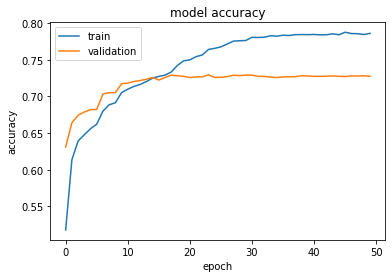

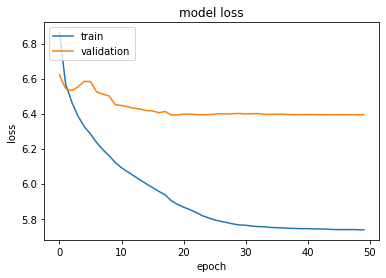

In [25]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Testing

In [26]:
test_model = NeuralLM(
    embedding_size,
    num_layers,
    hidden_size,
    vocab_size,
    dropout
).to(device)

test_model.load_state_dict(torch.load(MODEL_CHECKPOINT))


# test_dataset = LanguageModelingDataset(test_processed_file,english)


<All keys matched successfully>

In [27]:
def calculate_perplexity_exp(P):
        return (P * np.log(P))/np.log(2)

In [28]:
def calculate_sentence_perplexity(probabilities):
    perplexity_exp = 0
    joint_prob = 1
    
    #ngram_probab = np.sum(probabilities)
    
    for probability in probabilities:
        joint_prob *= probability
        perplexity_exp += calculate_perplexity_exp(joint_prob)
    
    overall_perplexity = 2**(-perplexity_exp)
    
    return overall_perplexity,joint_prob

In [32]:
def evaluateNLM(model,device,test_sentences,english_field,test_batch_size,window_len):
    
    def write_temp_file(sentence,filename,):
        temp_file = open(filename,'w',encoding='utf-8')
        temp_file.write(sentence)
        temp_file.close()

    def get_test_accuracy(y_pred,y_true):
        return (y_pred == y_true).sum().item() / y_pred.shape[1]
    
    
    temp_test_file = 'temp_test_file.txt'
        
    model.eval()
    
    tot_test_loss = 0 

    loss = []
    
    all_perp = []
    curr_test_acc  = 0
    all_acc = []
    
    for sentence in tqdm(test_sentences):
        write_temp_file(sentence,temp_test_file)
        test_dataset = LanguageModelingDataset(temp_test_file,english_field)
        
        test_iterator = TestIterator(test_dataset,test_batch_size,window_len)
        
        curr_acc = 0
        perp = []
        
        for test_batch in test_iterator:
            test_text = test_batch.text
            test_target = test_batch.target
            
            with torch.no_grad():
                
                h_i,c_i = model.init_state(test_batch_size,device)
                
                test_predictions,(h_i,c_i) = model(test_text,(h_i,c_i))

                #print(test_predictions)
                test_loss = criterion(test_predictions.permute(0,2,1),test_target)
                
                loss.append(test_loss.item())
                
                #perp.append(math.exp(test_loss.item()))
                
                probabilities = model.softmax(test_predictions)
                
                real_prob, pred_indices = torch.max(probabilities,dim=2)
                
                real_prob = real_prob.detach().cpu().numpy()
                
                curr_test_acc += get_test_accuracy(pred_indices,test_target)
                
                ngram_perplexity,ngram_probability = calculate_sentence_perplexity(real_prob)
                perp.append(ngram_perplexity)
                
        
        try:
            perp_mean = np.mean(perp)
            all_perp.append(perp_mean)
            all_acc.append(curr_acc / len(test_iterator))
        except:
            pass

        

    return loss,all_perp,all_acc
    

In [30]:
import math

In [47]:
test_batch_size = 1
test_window_len = 5

loss,perp,acc = evaluateNLM(test_model,device,test,english,test_batch_size,test_window_len)

In [34]:
math.exp(np.mean(loss))

385.27503633620955

In [35]:
perp2 = [p for p in perp if p > 0]
np.mean(perp2)

1.4539511

In [50]:
math.exp(np.mean(loss))

385.27503638671277

In [48]:
perp2 = [p for p in perp if p > 0]

In [49]:
np.mean(perp2)

1.4539511

In [46]:
train_perp_file = open('train_perp.txt','w',encoding='utf-8')

for i in tqdm(range(len(perp2))):
  sentence = train[i].rstrip('\n')
  to_write = f'{sentence}\t{perp2[i]}\n'
  train_perp_file.write(to_write)

train_perp_file.write(f'{np.mean(perp2)}\n')
train_perp_file.close()

In [52]:
test_perp_file = open('test_perp.txt','w',encoding='utf-8')

for i in tqdm(range(len(perp2))):
  sentence = test[i].rstrip('\n')
  to_write = f'{sentence}\t{perp2[i]}\n'
  test_perp_file.write(to_write)

test_perp_file.write(f'{np.mean(perp2)}\n')
test_perp_file.close()

In [51]:
len(perp2)

10000